In [52]:
import face_recognition
import cv2
import numpy as np
from matplotlib import pyplot as plt

from brisque import BRISQUE

import json_tricks
import json

brisq = BRISQUE()


Reference image BRISQUE score: 43.452874953906075


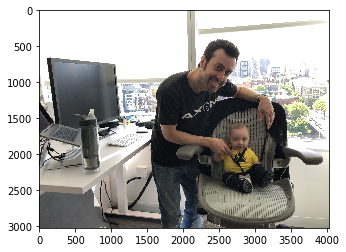

In [53]:
size = (256, 341)
image_path = "photos/IMG_1595.jpg"

image = face_recognition.load_image_file(image_path)
plt.imshow(image)

print('Reference image BRISQUE score: %s' % brisq.get_score(image))

In [54]:
laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()
print("Blur: " + str(laplacian_var))


Blur: 176.93090497016013


In [55]:
face_locations = face_recognition.face_locations(image, model="hog")
if len(face_locations) == 0:
    print("no faces found!")
    raise

In [56]:
# detect 68-landmarks from image. This includes left eye, right eye, lips, eye brows, nose and chins
face_landmarks = face_recognition.face_landmarks(image, face_locations)



In [57]:
face_index = 0
print(face_landmarks[face_index])

{'chin': [(2641, 1765), (2644, 1802), (2647, 1838), (2656, 1873), (2674, 1903), (2699, 1926), (2728, 1943), (2759, 1957), (2786, 1959), (2811, 1953), (2834, 1936), (2859, 1919), (2884, 1900), (2900, 1875), (2909, 1844), (2915, 1813), (2921, 1778)], 'left_eyebrow': [(2679, 1775), (2702, 1763), (2728, 1758), (2754, 1761), (2781, 1770)], 'right_eyebrow': [(2826, 1769), (2848, 1761), (2871, 1758), (2892, 1761), (2906, 1773)], 'nose_bridge': [(2804, 1800), (2804, 1817), (2805, 1835), (2805, 1853)], 'nose_tip': [(2776, 1866), (2789, 1869), (2802, 1872), (2813, 1869), (2823, 1865)], 'left_eye': [(2711, 1799), (2728, 1793), (2747, 1793), (2762, 1804), (2745, 1809), (2727, 1809)], 'right_eye': [(2830, 1803), (2844, 1791), (2862, 1790), (2878, 1796), (2864, 1806), (2846, 1808)], 'top_lip': [(2745, 1896), (2767, 1894), (2788, 1891), (2799, 1894), (2809, 1891), (2823, 1893), (2838, 1894), (2830, 1897), (2809, 1898), (2798, 1900), (2787, 1899), (2753, 1898)], 'bottom_lip': [(2838, 1894), (2822, 191

Pose: 0.4576271186440678
Smile: 0.325
Scale: 0.6507539920622473


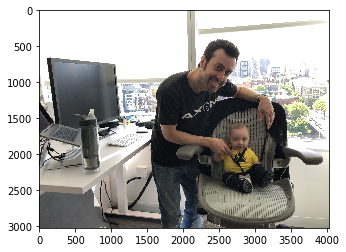

In [58]:
'''
Let's find the angle of the face. First calculate 
the center of left and right eye by using eye landmarks.
'''
leftEyePts = face_landmarks[face_index]['left_eye']
rightEyePts = face_landmarks[face_index]['right_eye']
nosePts = face_landmarks[face_index]['nose_tip']
topLipPts = face_landmarks[face_index]['top_lip']
bottomLipPts = face_landmarks[face_index]['bottom_lip']

leftEyeCenter = np.array(leftEyePts).mean(axis=0).astype("int")
rightEyeCenter = np.array(rightEyePts).mean(axis=0).astype("int")
noseCenter = np.array(nosePts).mean(axis=0).astype("int")
topLipCenter = np.array(topLipPts).mean(axis=0).astype("int")
bottomLipCenter = np.array(bottomLipPts).mean(axis=0).astype("int")

pose = (rightEyeCenter[0] - noseCenter[0]) / (rightEyeCenter[0] - leftEyeCenter[0])
print("Pose: " + str(pose))

smile = (bottomLipCenter[1] - topLipCenter[1]) / (bottomLipCenter[1] - noseCenter[1])
print("Smile: " + str(smile))

leftEyeCenter = (leftEyeCenter[0],leftEyeCenter[1])
rightEyeCenter = (rightEyeCenter[0],rightEyeCenter[1])
noseCenter = (noseCenter[0],noseCenter[1])
topLipCenter = (topLipCenter[0],topLipCenter[1])
bottomLipCenter = (bottomLipCenter[0],bottomLipCenter[1])


# draw the circle at centers and line connecting to them
'''
cv2.circle(image, noseCenter, 10, (0, 0, 255), 10)
cv2.circle(image, topLipCenter, 10, (255, 0, 0), 10)
cv2.circle(image, bottomLipCenter, 10, (255, 0, 0), 10)
cv2.circle(image, leftEyeCenter, 5, (255, 0, 0), 10)
cv2.circle(image, rightEyeCenter, 5, (0, 255, 0), 10)
cv2.line(image, (leftEyeCenter[0], 0), (leftEyeCenter[0], -500), (255, 0, 0), 100)
'''

# find the angle of line by using slop of the line.
dY = rightEyeCenter[1] - leftEyeCenter[1]
dX = rightEyeCenter[0] - leftEyeCenter[0]
angle = np.degrees(np.arctan2(dY, dX))

# to get the face at the center of the image,
# set desired left eye location. Right eye location 
# will be found out by using left eye location.
# this location is in percentage.
desiredLeftEye = (0.35, 0.5)
#Set the croped image(face) size after rotaion.
(desiredFaceWidth, desiredFaceHeight) = size

desiredRightEyeX = 1.0 - desiredLeftEye[0]
 
# determine the scale of the new resulting image by taking
# the ratio of the distance between eyes in the *current*
# image to the ratio of distance between eyes in the
# *desired* image
dist = np.sqrt((dX ** 2) + (dY ** 2))
desiredDist = (desiredRightEyeX - desiredLeftEye[0])
desiredDist *= desiredFaceWidth
scale = desiredDist / dist

print("Scale: " + str(scale))

# compute center (x, y)-coordinates (i.e., the median point)
# between the two eyes in the input image
eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
    (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

plt.imshow(image)

In [59]:
# grab the rotation matrix for rotating and scaling the face
M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

# update the translation component of the matrix
tX = desiredFaceWidth * 0.5
tY = desiredFaceHeight * desiredLeftEye[1] # + 40

M[0, 2] += (tX - eyesCenter[0])
M[1, 2] += (tY - eyesCenter[1])

print(tX, tY)

# apply the affine transformation
(w, h) = (desiredFaceWidth, desiredFaceHeight)

print(w, h)

print(M)

transformed_image = cv2.warpAffine(image, M, (w, h),
    flags=cv2.INTER_CUBIC)



128.0 170.5
256 341
[[ 6.50660540e-01 -1.10281447e-02 -1.67074555e+03]
 [ 1.10281447e-02  6.50660540e-01 -1.03151264e+03]]


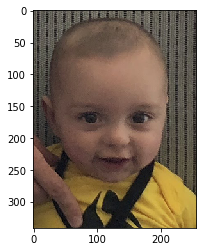

In [60]:
plt.imshow(transformed_image)

In [61]:
print('BRISQUE score of transformed image: %s' % brisq.get_score(transformed_image))

laplacian_var = cv2.Laplacian(transformed_image, cv2.CV_64F).var()
print("Blur of transformed image: " + str(laplacian_var))

BRISQUE score of transformed image: 18.273434339498294
Blur of transformed image: 890.949214435141


In [62]:
# detect 68-landmarks from image. This includes left eye, right eye, lips, eye brows, nose and chins
face_landmarks = face_recognition.face_landmarks(transformed_image)



In [63]:
leftEyePts = face_landmarks[0]['left_eye']
rightEyePts = face_landmarks[0]['right_eye']
nosePts = face_landmarks[0]['nose_tip']
topLipPts = face_landmarks[0]['top_lip']
bottomLipPts = face_landmarks[0]['bottom_lip']

leftEyeCenter = np.array(leftEyePts).mean(axis=0).astype("int")
rightEyeCenter = np.array(rightEyePts).mean(axis=0).astype("int")
noseCenter = np.array(nosePts).mean(axis=0).astype("int")
topLipCenter = np.array(topLipPts).mean(axis=0).astype("int")
bottomLipCenter = np.array(bottomLipPts).mean(axis=0).astype("int")

pose = (rightEyeCenter[0] - bottomLipCenter[0]) / (rightEyeCenter[0] - leftEyeCenter[0])
print("Pose: " + str(pose))

smile = (bottomLipCenter[1] - topLipCenter[1]) / (bottomLipCenter[1] - noseCenter[1])
print("Smile: " + str(smile))

leftEyeCenter = (leftEyeCenter[0],leftEyeCenter[1])
rightEyeCenter = (rightEyeCenter[0],rightEyeCenter[1])
noseCenter = (noseCenter[0],noseCenter[1])
topLipCenter = (topLipCenter[0],topLipCenter[1])
bottomLipCenter = (bottomLipCenter[0],bottomLipCenter[1])


# draw the circle at centers and line connecting to them
cv2.circle(transformed_image, noseCenter, 5, (0, 0, 255), 10)
cv2.circle(transformed_image, topLipCenter, 5, (255, 0, 0), 10)
cv2.circle(transformed_image, bottomLipCenter, 5, (255, 0, 0), 10)
cv2.circle(transformed_image, leftEyeCenter, 5, (255, 0, 0), 10)
cv2.circle(transformed_image, rightEyeCenter, 5, (0, 255, 0), 10)


Pose: 0.5194805194805194
Smile: 0.30434782608695654


array([[[ 86,  83,  76],
        [ 79,  76,  70],
        [ 93,  90,  83],
        ...,
        [ 56,  50,  51],
        [ 68,  63,  60],
        [119, 114, 110]],

       [[ 93,  90,  83],
        [110, 107, 101],
        [108, 105,  98],
        ...,
        [ 82,  78,  74],
        [ 86,  81,  78],
        [112, 107, 103]],

       [[ 89,  86,  79],
        [ 98,  95,  89],
        [104, 101,  94],
        ...,
        [ 36,  31,  28],
        [ 62,  57,  54],
        [106, 101,  97]],

       ...,

       [[108,  90,  44],
        [108,  90,  44],
        [106,  88,  42],
        ...,
        [164, 135,  51],
        [168, 138,  52],
        [165, 135,  48]],

       [[106,  88,  42],
        [105,  87,  41],
        [113,  95,  49],
        ...,
        [164, 135,  51],
        [166, 135,  51],
        [163, 133,  46]],

       [[109,  89,  42],
        [106,  86,  37],
        [117,  97,  48],
        ...,
        [163, 134,  51],
        [164, 133,  50],
        [167, 136,  53]]

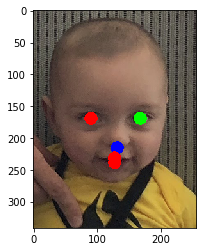

In [64]:
plt.imshow(transformed_image)